Run with Python 3.5+. Make sure the following dependencies are installed in your conda environment:
- `matplotlib`
- `numpy`
- `pandas`
- `scipy`
- `seaborn`
- `statsmodels`

(Most of these should be available in the conda environment by default)

In [1]:
from collections import defaultdict
from functools import reduce
from glob import glob
import os

import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import seaborn as sns
from statsmodels.stats.multitest import multipletests

%matplotlib inline

In [2]:
plt.style.use('seaborn-white')
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.rcParams["font.family"] = "sans-serif"

## Load data

We have provided a `misclassified_samples_analysis.tar.gz` file that should be decompressed before running this Jupyter notebook. Move `DATA_DIR` and `OUTPUT_DIR` to the top-level of the GitHub, or update these paths accordingly.
The `.tar.gz` contains both the input data files in `DATA_DIR` and the figures generated from this notebook in `OUTPUT_DIR`

In [3]:
DATA_DIR = './data.Results_tsv'
OUTPUT_DIR = './figures.misclassified_samples'
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
X_test_df = pd.read_csv(os.path.join(DATA_DIR, 'allvars.x_test.tsv'), sep='\t')
X_test_df.head()

,dep_name.C,dep_name.B,dep_name.A,esi.1,esi.2,esi.3,esi.4,esi.5,age,gender.Female,...,cc_vaginaldischarge,cc_vaginalpain,cc_weakness,cc_wheezing,`cc_withdrawal-alcohol`,cc_woundcheck,cc_woundinfection,`cc_woundre-evaluation`,cc_wristinjury,cc_wristpain
499849,0,1,0,0.0,0.0,0.0,1.0,0.0,32.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208411,0,1,0,0.0,0.0,0.0,1.0,0.0,38.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
355190,0,0,1,0.0,1.0,0.0,0.0,0.0,73.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
469227,0,1,0,0.0,0.0,1.0,0.0,0.0,22.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
465313,0,1,0,0.0,0.0,1.0,0.0,0.0,36.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y_test = pd.read_csv(os.path.join(DATA_DIR, 'allvars.y_test.tsv'), sep='\t').values.T[0]

The authors provide descriptions for some of the variables in Table S1. 

In [6]:
info_on_variables = pd.read_csv(os.path.join(DATA_DIR, 'pone.0201016.s001.csv'),
                                header=None,
                                names=['misc', 'variable', 'description', 'type'])
info_on_variables.head()

,misc,variable,description,type
0,Demographics,age,age,Numeric
1,NaN,gender,gender,Binary
2,NaN,ethnicity,ethnicity,Categorical
3,NaN,race,race,Categorical
4,NaN,lang,patient's primary language (English vs. other),Binary


In [7]:
variable_type = {}
for row in info_on_variables.itertuples():
    variable_type[row.variable] = row.type

In [8]:
def adjust_categorical(Xs, allvars, variable_type):
    """
    Collapse the columns corresponding to categorical variables into a
    single column storing the index == 1 
    """
    variable_ixs = defaultdict(list)
    for i, v in enumerate(allvars):
        Xv = Xs[:, i][~np.isnan(Xs[:, i])]
        if '.' in v and v not in variable_type and \
                variable_type[v.split('.')[0]] == 'Categorical':
            variable_ixs[v.split('.')[0]].append(i)
        elif '.' in v and np.all(Xv == Xv.astype(bool)):  # for some reason it's one-hot encoded...
            variable_ixs[v.split('.')[0]].append(i)
        else:
            variable_ixs[v].append(i)
    new_Xs = []
    clean_labels = []
    for v, c in variable_type.items():
        if v not in variable_ixs:
            continue
        ixs = variable_ixs[v]
        clean_labels.append(v)
        if c == 'Categorical' or len(ixs) > 1:
            collapse_X = np.argmax(Xs[:, ixs], axis=1).reshape((len(Xs), 1))
            new_Xs.append(collapse_X)
        else:
            new_Xs.append(Xs[:, ixs])
    return np.hstack(new_Xs), clean_labels

In [9]:
source_X_test = {}
source_vars = {}
sample_ids = None
for fp in glob(os.path.join(DATA_DIR, '*x_test.tsv')):
    data_used = os.path.basename(fp).split('.')[0]
    df = pd.read_csv(fp, sep='\t')
    
    X_test = df.values
    variables = [v if '`' not in v else v[1:-1]
                 for v in df.columns]
    source_X_test[data_used], source_vars[data_used] = adjust_categorical(
        X_test, variables, variable_type)
    if sample_ids is None:
        sample_ids = df.index.tolist()    
    print(data_used, len(source_vars[data_used]))


triage 222
topvars 62
allvars 966
hx 753


The categorical variables are one-hot encoded. For each variable, map index to category so we can use it for interpretation later.

In [10]:
categorical_var_interpret = {}
for variable in source_vars['allvars']:
    multivar = []
    for v in X_test_df.columns:
        if '.' in v and variable == v[:len(variable)]:
            multivar.append(v)
    if len(multivar) > 1:
        categorical_var_interpret[variable] = \
            {ix: v.split('.')[1] for (ix, v) in enumerate(multivar)}

In [11]:
model_to_label = {
    'hx.lr': 'Logistic Regr (Patient history)',
    'hx.keras': 'DNN (Patient history)',
    'hx.bst': 'XGBoost (Patient history)',
    'triage.lr': 'Logistic Regr (Triage)',
    'triage.keras': 'DNN (Triage)',
    'triage.bst': 'XGBoost (Triage)',
    'allvars.lr': 'Logistic Regr (All vars)',
    'allvars.keras': 'DNN (All vars)',
    'allvars.bst': 'XGBoost (All vars)',
    'topvars.bst': 'XGBoost (Top vars)',
}

Load the predicted labels made by each model

In [12]:
model_predictions = {}
groupby_modeltype = defaultdict(list)
groupby_datatype = defaultdict(list)
for fp in glob(os.path.join(DATA_DIR, '*pred_test*.tsv')):
    model_name = os.path.basename(fp).split('_')[0]
    model_predictions[model_name] = \
        pd.read_csv(fp, sep='\t').values.T[0]
    datatype, modeltype = model_name.split('.')
    groupby_modeltype[modeltype].append(model_name)
    groupby_datatype[datatype].append(model_name)

In [13]:
model_predictions.keys()

dict_keys(['hx.lr', 'hx.bst', 'triage.lr', 'topvars.bst', 'hx.keras', 'triage.keras', 'allvars.lr', 'triage.bst', 'allvars.keras', 'allvars.bst'])

## identify misclassified samples
The `threshold_for_samples` data structure stores the threshold values specified in Hong et al.'s [code](https://github.com/yaleemmlc/admissionprediction/blob/master/youdens.R). The thresholds determine whether a probabilistic label is converted into 0 or 1 and maintain the desired specificity rate of 0.85. 

In [14]:
threshold_for_samples = {
    'allvars.bst': 0.2968,
    'triage.bst': 0.42,
    'hx.bst': 0.3,
    'topvars.bst': 0.29,
    'allvars.lr': 0.34,
    'triage.lr': 0.43,
    'hx.lr': 0.28,
    'allvars.keras': 0.28,
    'triage.keras': 0.39,
    'hx.keras': 0.30,
}

binarize predictions based on the prespecified thresholds and collect misclassified samples

In [15]:
model_misclassified = {}
for model_tag, threshold in threshold_for_samples.items():
    model_misclassified[model_tag] = np.where(
        (model_predictions[model_tag] > threshold).astype(int) != y_test)[0]

In [16]:
print("Model\tProp misclassified\tNumber misclassified")
for model_tag, mc_ixs in model_misclassified.items():
    print('{0}\t{1:.3f}\t{2}'.format(model_tag, len(mc_ixs) / len(y_test), len(mc_ixs)))

Model	Prop misclassified	Number misclassified
allvars.bst	0.148	8283
triage.bst	0.192	10759
hx.bst	0.178	9981
topvars.bst	0.164	9207
allvars.lr	0.156	8744
triage.lr	0.199	11168
hx.lr	0.185	10333
allvars.keras	0.165	9260
triage.keras	0.191	10679
hx.keras	0.192	10749


## determine variables where misclassified samples are significantly different from the rest of the test set

In [17]:
datatype = 'allvars'
allvars_X_test = source_X_test[datatype]
allvars_cvar_ixs = source_vars[datatype]
allvars_query_dict = {v: ix for (ix, v) in enumerate(source_vars['allvars'])}

def get_from_allvars_mat(var):
    return allvars_X_test[:, allvars_query_dict[var]]

Handle numeric (includes continuous) and categorical (includes binary variables) differently. 

For numeric variables, we apply the Mann-Whitney U test (i.e. rank sum) to determine if the distribution of a given variable significantly differs for misclassified samples compared to all test samples. 

For categorical variables, we compute the logFC enrichment of the proportion misclassified in a variable's category vs the proportion of all samples in a variable's category, i.e. `ln(prop_misclassified_in_category / prop_all_samples_in_category)`

In [18]:
def compare_numeric(Xvar_mc, Xvar_test):
    s, pvalue = mannwhitneyu(Xvar_mc, Xvar_test, alternative='two-sided')
    auc = s / (len(Xvar_mc) * len(Xvar_test))
    return auc, pvalue

In [19]:
def compare_categorical(Xvar_mc, Xvar_test, vartype):
    unique_values = np.unique(Xvar_mc, axis=0)
    # this if-statement is here because I found during a manual check
    # that some vars have a single nonbinary sample...
    if vartype == 'Binary' and len(unique_values) > 2:
        unique_values = [0., 1.]  
    mc_value_enrichment = defaultdict(float)
    for v in unique_values:
        mc_row_ixs = np.where(Xvar_mc == v)[0]
        all_row_ixs = np.where(Xvar_test == v)[0]
        
        mc_value_enrichment[v] = np.log(
            (len(mc_row_ixs) / len(Xvar_mc)) /
            (len(all_row_ixs) / len(Xvar_test)))
    return mc_value_enrichment 

In [20]:
def misclassified_sample_vars(all_X_test, mc_ixs, variables, variable_type):
    numeric_var_ranksum = {}
    categ_var_enrichment = {}
    for i, variable in enumerate(variables):
        X_var = all_X_test[:, i]
        mc_X_var = X_var[mc_ixs]
        
        X_var = X_var[~np.isnan(X_var)]
        mc_X_var = mc_X_var[~np.isnan(mc_X_var)]
        if len(X_var) == 0 or len(mc_X_var) == 0:
            continue
        if len(np.unique(X_var)) == 1: # skip if all samples have same value
            continue

        if variable_type[variable] == 'Numeric' and len(np.unique(X_var)) > 2:
            numeric_var_ranksum[variable] = compare_numeric(
                mc_X_var, X_var)
        else:  
            categ_var_enrichment[variable] = compare_categorical(
                mc_X_var, X_var, vartype=variable_type[variable])
    return numeric_var_ranksum, categ_var_enrichment

In [21]:
model_misclassification_info = {}
for datatype, model_tags in groupby_datatype.items():
    X_test = source_X_test[datatype]
    for mt in model_tags:
        print("Processing {0}".format(mt))
        numeric_var_ranksum, categ_var_enrichment = misclassified_sample_vars(
            X_test, model_misclassified[mt], source_vars[datatype], variable_type)
        model_misclassification_info[mt] = {
            'numeric_vars_ranksum': numeric_var_ranksum,
            'categorical_vars_enrichment': categ_var_enrichment,
        }

Processing hx.lr
Processing hx.bst
Processing hx.keras
Processing triage.lr
Processing triage.keras
Processing triage.bst
Processing topvars.bst
Processing allvars.lr
Processing allvars.keras
Processing allvars.bst


Collect all p-values from rank sum test to apply FDR correction (Benjamini--Hochberg)

In [22]:
mt_numvars_pvalues = {}
mt_numvars_aucs = {}
for mt, mc_info in model_misclassification_info.items():
    numvar_ranksum = mc_info['numeric_vars_ranksum']
    for variable, (auc, pvalue) in numvar_ranksum.items():
        mt_numvars_pvalues[(mt, variable)] = pvalue
        mt_numvars_aucs[(mt, variable)] = auc

In [23]:
cutoff = 1e-4
_, fdr_pvs, _, _ = multipletests(
    list(mt_numvars_pvalues.values()), alpha=cutoff, method='fdr_bh', is_sorted=False)
fdr_pvs = np.array(fdr_pvs)

print('Number below cutoff of {0}: {1} out of {2}'.format(
    cutoff, len(fdr_pvs[fdr_pvs < cutoff]), len(fdr_pvs)))

Number below cutoff of 0.0001: 595 out of 2695


In [24]:
modeltype_numvar_fdrs = defaultdict(dict)
for (mt, variable), fdr_pv in zip(list(mt_numvars_pvalues.keys()), fdr_pvs):
    modeltype_numvar_fdrs[mt][variable] = fdr_pv
    if fdr_pv < cutoff:
        print('{0}\t{1}\t{2}'.format(mt, variable, fdr_pv))

hx.lr	age	7.448484496976032e-240
hx.lr	n_admissions	3.6021506648190024e-125
hx.lr	n_surgeries	1.0599958862852807e-58
hx.lr	meds_analgesics	2.1474959146828072e-06
hx.lr	meds_anesthetics	4.473607438839315e-05
hx.lr	meds_antiasthmatics	4.298404229367939e-09
hx.lr	meds_anticoagulants	2.6000880129530242e-19
hx.lr	meds_antifungals	8.147905592195931e-08
hx.lr	meds_antihyperglycemics	7.442783636163816e-06
hx.lr	meds_antiplateletdrugs	2.929461245478233e-13
hx.lr	meds_cardiacdrugs	2.8570425280640323e-15
hx.lr	meds_cardiovascular	2.616141797951577e-07
hx.lr	meds_colonystimulatingfactors	9.379767934579976e-06
hx.lr	meds_diuretics	4.698353348865097e-20
hx.lr	meds_eentpreps	2.8104539810313485e-06
hx.lr	meds_elect/caloric/h2o	4.850273400873591e-16
hx.lr	meds_gastrointestinal	6.5203131301419685e-18
hx.lr	meds_hormones	2.614421313078842e-09
hx.lr	meds_skinpreps	1.2245395401168356e-05
hx.lr	meds_thyroidpreps	3.740925903124833e-06
hx.lr	meds_unclassifieddrugproducts	2.8624100063311995e-10
hx.lr	meds_vita

### figures for numeric variables

In [25]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='custom_reds', 
    colors=['white', '#FBDBDA', '#F9C9C8', '#F5A6A3', '#EE706B', '#EA4C46', '#D3443F', '#8C2E2A','#752623']
)

In [26]:
HEATMAP_FIGURES_DIR = os.path.join(OUTPUT_DIR, 'numeric_vars_heatmaps')
os.makedirs(HEATMAP_FIGURES_DIR, exist_ok=True)
def build_heatmap_for_variables(variables,
                                use_models,
                                modeltype_numvar_fdrs,
                                figsize=(10, 20),
                                title=None,
                                filename=None):
    model_fdr_mat = np.zeros(
        (len(variables), len(use_models)))
    for c, mt in enumerate(use_models):
        numvar_fdrs = modeltype_numvar_fdrs[mt]
        for r, v in enumerate(variables):
            if v in numvar_fdrs:
                model_fdr_mat[r, c] = -np.log10(numvar_fdrs[v])
            else:
                model_fdr_mat[r, c] = np.nan
    
    rm_nans = ~np.isnan(model_fdr_mat).any(axis=1)
    model_fdr_mat = model_fdr_mat[rm_nans]
    variables = np.array(variables)[rm_nans]
    
    select_N = 50
    top_N_ixs = np.argsort(-1 * np.max(model_fdr_mat, axis=1))[:select_N]
    variables = variables[top_N_ixs]
    model_fdr_mat = model_fdr_mat[top_N_ixs]
    
    
    df = pd.DataFrame(model_fdr_mat.T)
    df.columns = variables
    df.rename(index={i: model_to_label[m] for (i, m) in enumerate(use_models)}, inplace=True)
    df = df[(df > 2).any(1)]
    df = df.dropna(axis=1, how='all')
    
    sns.set(font_scale=1.5)
    
    plt.figure(figsize=figsize)
    cm = sns.clustermap(df, figsize=figsize,
                        linewidths=0.1, 
                        yticklabels=1,
                        cmap=cmap,
                        norm=colors.LogNorm(),)
    cm.ax_row_dendrogram.set_visible(False)
    cm.ax_col_dendrogram.set_visible(False)
    
    if title is not None and filename is not None:
        plt.title(title)
        cm.savefig(os.path.join(
            HEATMAP_FIGURES_DIR, '{0}.{1}.pdf'.format(filename, select_N)), dpi=300)
    return df
    
    

<Figure size 2160x360 with 0 Axes>

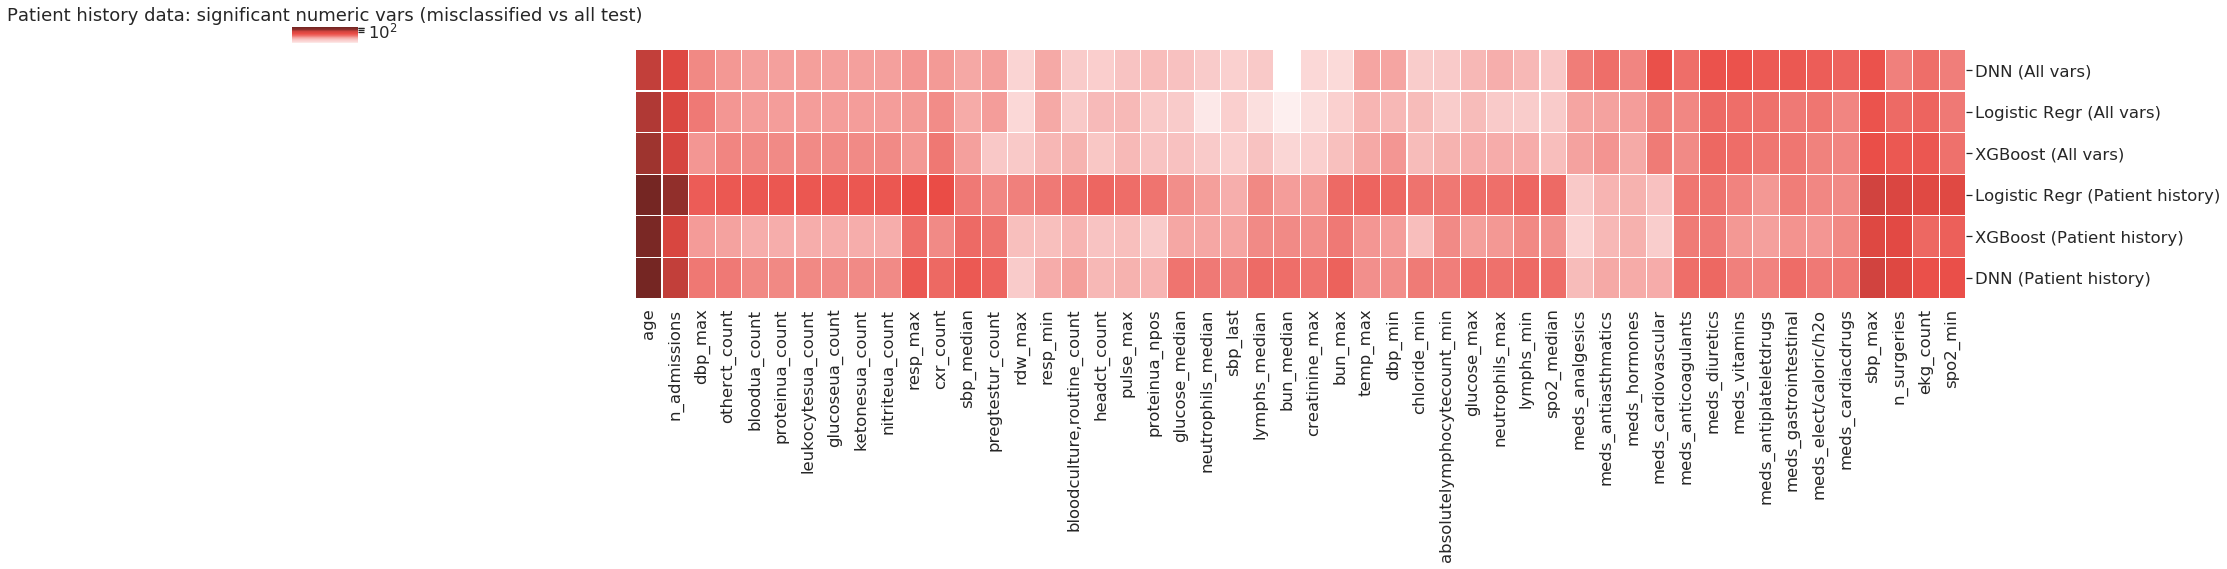

In [27]:
df = build_heatmap_for_variables(
    source_vars['hx'],
    groupby_datatype['hx'] + groupby_datatype['allvars'],
    modeltype_numvar_fdrs,
    figsize=(30, 5),
    title='Patient history data: significant numeric vars (misclassified vs all test)',
    filename='numeric.hx')

<Figure size 360x288 with 0 Axes>

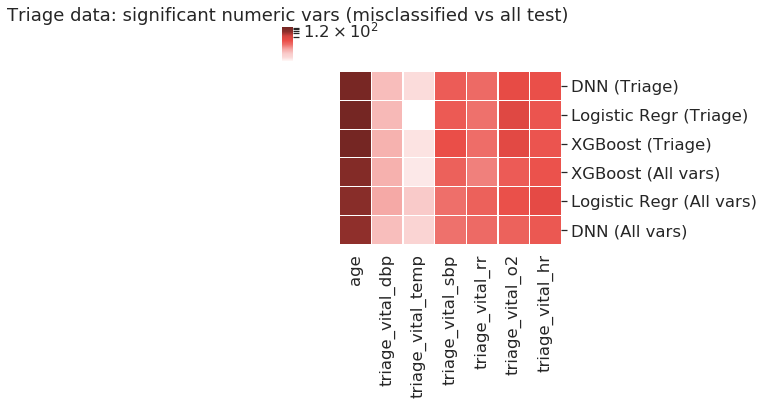

In [28]:
df = build_heatmap_for_variables(
    source_vars['triage'],
    groupby_datatype['triage'] + groupby_datatype['allvars'],
    modeltype_numvar_fdrs,
    figsize=(5, 4),
    title='Triage data: significant numeric vars (misclassified vs all test)',
    filename='numeric.triage')

In [29]:
def get_exact_mean_for_variable(var):
    all_samples = get_from_allvars_mat(var)
    for mt, ixs in model_misclassified.items():
        mc_samples = all_samples[ixs]
        mc_samples = mc_samples[~np.isnan(mc_samples)]
        print('{0}: {1:.3f}'.format(model_to_label[mt], np.average(mc_samples)))
    all_samples = all_samples[~np.isnan(all_samples)]
    print('Global average: {0:.3f}'.format(
        np.average(all_samples[~np.isnan(all_samples)])))

In [30]:
get_exact_mean_for_variable('age')

XGBoost (All vars): 55.194
XGBoost (Triage): 55.788
XGBoost (Patient history): 56.739
XGBoost (Top vars): 56.396
Logistic Regr (All vars): 54.681
Logistic Regr (Triage): 55.731
Logistic Regr (Patient history): 57.084
DNN (All vars): 54.212
DNN (Triage): 55.546
DNN (Patient history): 57.013
Global average: 49.962


In [31]:
get_exact_mean_for_variable('n_admissions')

XGBoost (All vars): 1.227
XGBoost (Triage): 1.380
XGBoost (Patient history): 1.185
XGBoost (Top vars): 1.320
Logistic Regr (All vars): 1.236
Logistic Regr (Triage): 1.398
Logistic Regr (Patient history): 1.340
DNN (All vars): 1.201
DNN (Triage): 1.398
DNN (Patient history): 1.197
Global average: 0.918


In [32]:
get_exact_mean_for_variable('n_surgeries')

XGBoost (All vars): 2.509
XGBoost (Triage): 2.698
XGBoost (Patient history): 2.580
XGBoost (Top vars): 2.585
Logistic Regr (All vars): 2.477
Logistic Regr (Triage): 2.696
Logistic Regr (Patient history): 2.612
DNN (All vars): 2.424
DNN (Triage): 2.698
DNN (Patient history): 2.596
Global average: 2.202


In [33]:
CONFINT_FIGURES_DIR = os.path.join(OUTPUT_DIR, 'numeric_vars_mean_confint')
os.makedirs(CONFINT_FIGURES_DIR, exist_ok=True)
def visualize_numeric_vars(sorted_variables,
                           sorted_fdrs,
                           misclassified_ixs,
                           model_tag,
                           top_N=30):
    sorted_variables = sorted_variables[sorted_fdrs < 1e-3]
    sorted_fdrs = sorted_fdrs[sorted_fdrs < 1e-3]
    
    bins = [1, 50, 100]
    build_df = []
    for v, fdr in zip(sorted_variables[:top_N], sorted_fdrs[:top_N]):
        X_var = get_from_allvars_mat(v)
        mc_X_var = X_var[misclassified_ixs]
        
        X_var = X_var[~np.isnan(X_var)]
        mc_X_var = mc_X_var[~np.isnan(mc_X_var)]
        
        var_mean = np.average(X_var)
        binned = None
        for b in bins:
            if var_mean < b:
                binned = b
                break
        if not binned:
            binned = bins[-1]
        
        baseline_records = [{'samples': 'all',
                             'variable': v, 
                             'value': x, 
                             'fdr': fdr,
                             'bin': binned}
                            for x in X_var]
        mc_records = [{'samples': 'misclassified', 
                       'variable': v, 
                       'value': x, 
                       'fdr': fdr,
                       'bin': binned}
                      for x in mc_X_var]
        build_df += baseline_records + mc_records
    
    df = pd.DataFrame(build_df)
    df_bins = df.bin.unique()
    N_subplots = len(df_bins)
    sns.set(font_scale=1.5)
    fig, axes = plt.subplots(nrows=1, ncols=N_subplots, figsize=(N_subplots * 8, 12))
    for i, b in enumerate(sorted(df_bins)):
        if N_subplots == 1:
            ax = axes
        else:
            ax = axes[i]
        g = sns.pointplot(y="value", x="variable", 
                          data=df[df['bin'] == b], 
                          hue='samples',
                          ci=95, linestyles='None',
                          errwidth=1, capsize=.15,
                          scale=.75, ax=ax)
        if i != 0:
            ax.get_legend().remove()
            
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.tight_layout()
    plt.savefig(
        os.path.join(CONFINT_FIGURES_DIR, 'numeric.{0}.ranksum.pdf'.format(mt)), dpi=300)
    plt.show()

In [ ]:
plt.style.use('seaborn-white')
sns.set(style="white")
sns.axes_style("white")
        
for modeltype, model_tags in groupby_modeltype.items():
    var_enrichment_vals = defaultdict(list)
    
    for i, mt in enumerate(model_tags):
        numvar_fdrs = modeltype_numvar_fdrs[mt]
        variables, fdrs = zip(*sorted(numvar_fdrs.items(), key=lambda tup: tup[1]))
        variables = np.array(variables)
        fdrs = np.array(fdrs)
        variables = variables[fdrs < 1e-3]
        fdrs = fdrs[fdrs < 1e-3]
        
        visualize_numeric_vars(
            np.array(variables), np.array(fdrs), model_misclassified[mt], mt, top_N=30)

### figures for categorical variables

In [35]:
for mt, mc_info in model_misclassification_info.items():
    print(mt)
    categ_var_enrichment = mc_info['categorical_vars_enrichment']
    for variable, value_enrichment in categ_var_enrichment.items():
        for v, enrichment in value_enrichment.items():
            if enrichment > 1.5:
                label = info_on_variables[
                    info_on_variables['variable'] == variable]['description'].tolist()[0]
                if isinstance(label, float):
                    label = variable
                print(label, variable_type[variable], v, enrichment)
    print()

hx.lr
PMH: Intrauterine hypoxia and birth asphyxia Binary 1.0 1.6900090335029312
PMH: E Codes: Poisoning Binary 1.0 1.6900090335029312
PMH: E Codes: Struck by; against Binary 1.0 1.6900090335029312
PMH: OB-related trauma to perineum and vulva Binary 1.0 1.6900090335029312
PMH: Hemolytic jaundice and perinatal jaundice Binary 1.0 1.6900090335029312
bloodculture,routine_last Binary 1.0 1.6900090335029312
bloodculture,routine_npos Numeric 1.0 1.6900090335029312

hx.bst
PMH: Fetal distress and abnormal forces of labor Binary 1.0 1.7246684050306997
bloodculture,routine_last Binary 1.0 1.7246684050306997
bloodculture,routine_npos Numeric 1.0 1.7246684050306997

hx.keras
PMH: Intrauterine hypoxia and birth asphyxia Binary 1.0 1.6505389637442227
PMH: Fetal distress and abnormal forces of labor Binary 1.0 1.6505389637442227
bloodculture,routine_last Binary 1.0 1.6505389637442227
bloodculture,routine_npos Numeric 1.0 1.6505389637442227

triage.lr
amulance, walk-in, car, etc Categorical 3.0 1.612

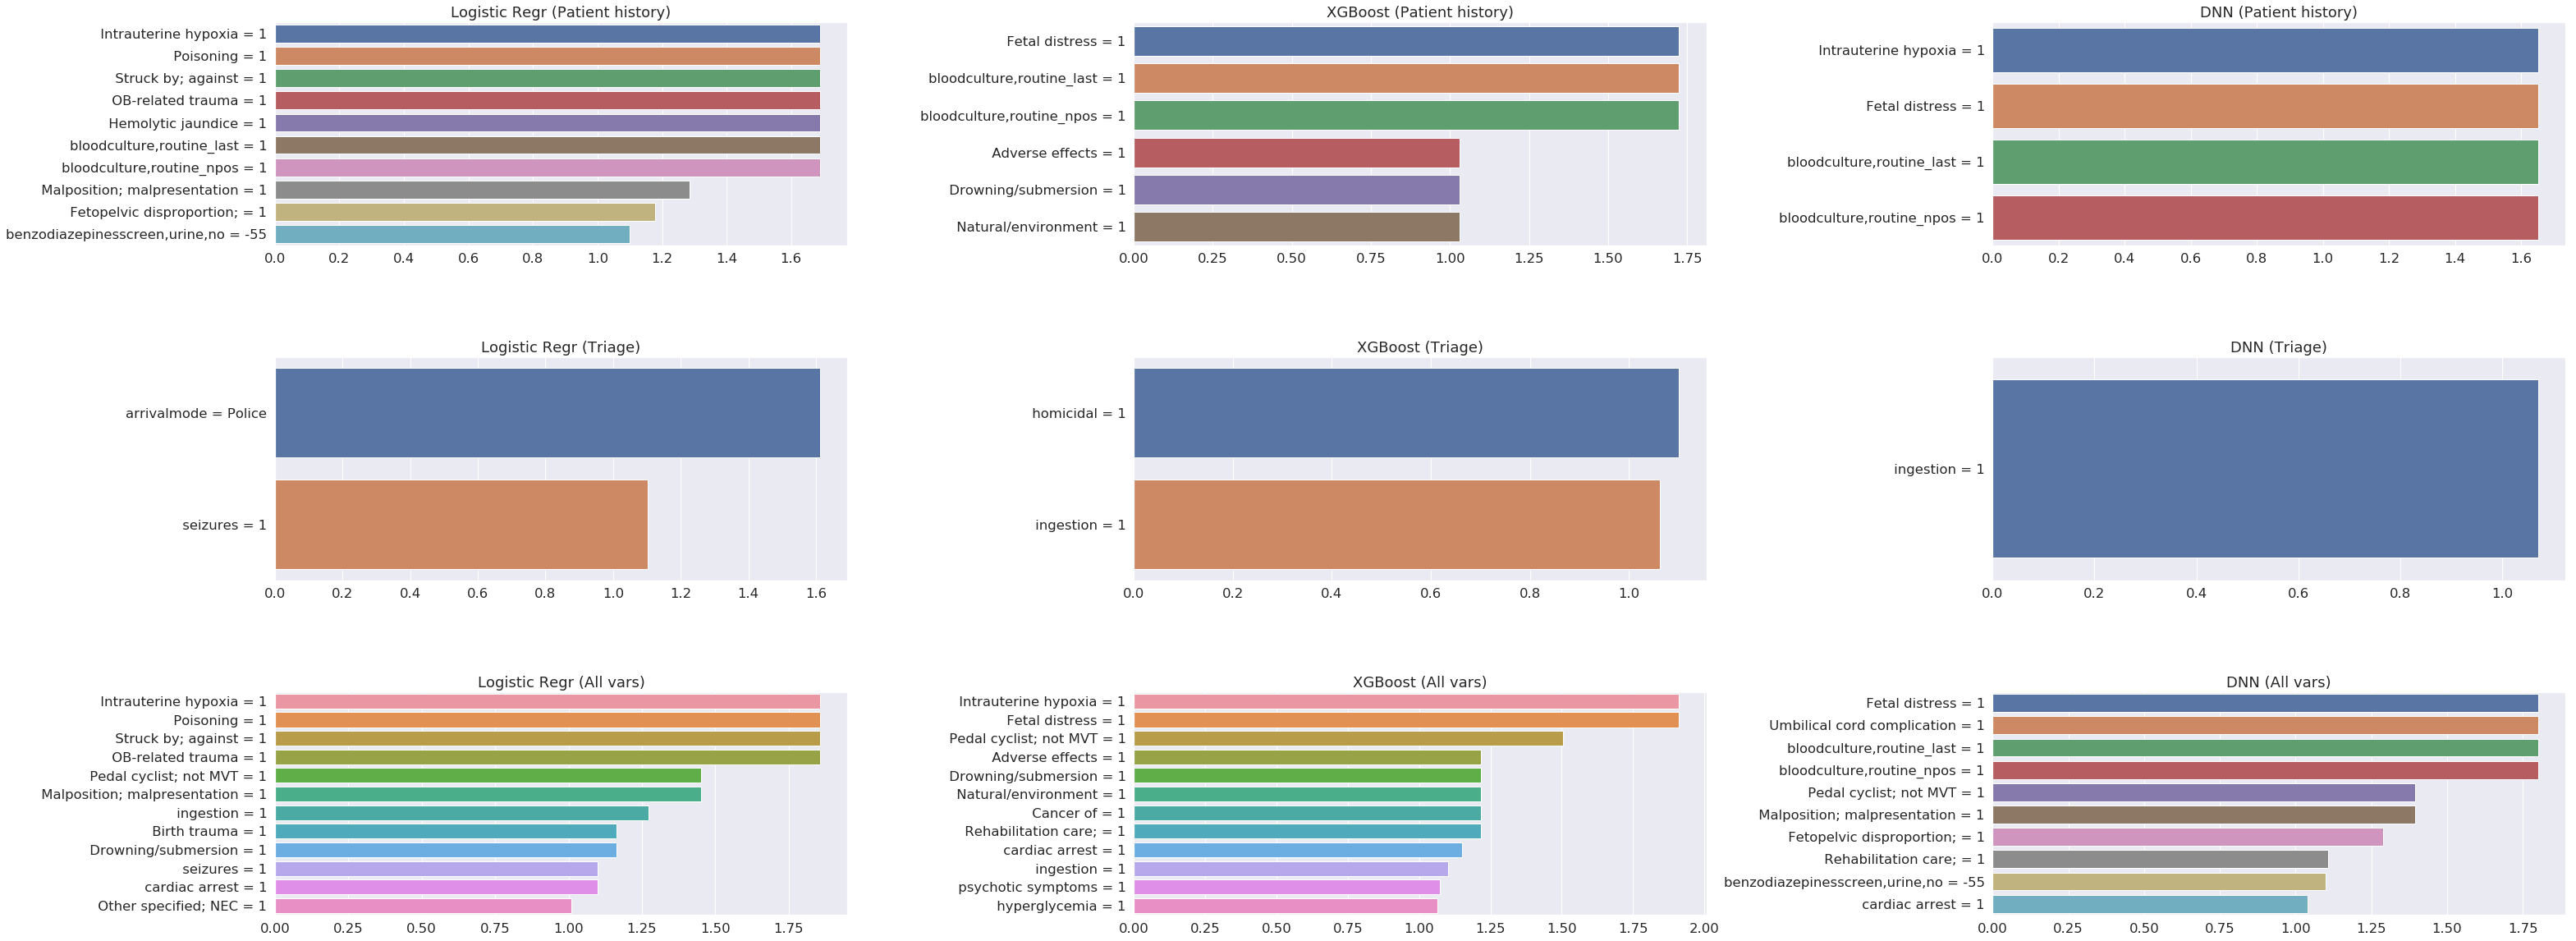

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(50, 20))
sns.set(font_scale=1.5)
for r, (modeltype, mt_list) in enumerate(groupby_modeltype.items()):
    count = 0
    for mt in mt_list:
        mc_info = model_misclassification_info[mt]
        categ_var_enrichment = mc_info['categorical_vars_enrichment']
        build_df = []
        var_enrichment = []
        for variable, value_enrichment in categ_var_enrichment.items():
            for v, enrichment in value_enrichment.items():
                if enrichment > 1:
                    if variable in categorical_var_interpret:
                        label = '{0} = {1}'.format(
                            variable, categorical_var_interpret[variable][v])
                    else:
                        label = info_on_variables[
                            info_on_variables['variable'] == variable]['description'].tolist()[0]
                        if isinstance(label, float):
                            label = variable
                        label = label.split(':')[-1]
                        if len(label) > 30:
                            label = ' '.join(label.split(':')[-1].split(' ')[:3])
                        if len(label) > 30:
                            label = label[:30]
                        label = '{0} = {1}'.format(label, int(v))

                    record = {
                        'label': label,
                        'enrichment': enrichment,
                        'variable': variable,
                        'vartype': variable_type[variable]
                    }
                    var_enrichment.append((label, enrichment))
                    build_df.append(record)
        if len(build_df) == 0:
            continue
        ax = axes[count, r]
        build_df = build_df[:12]
        df = pd.DataFrame(build_df)
        df = df.sort_values("enrichment", ascending=False)
        sns.barplot(data=df, y='label', x='enrichment', ax=ax)
        
        ax.set_title(model_to_label[mt])
        ax.set_xlabel('')
        ax.set_ylabel('')
        count += 1
plt.subplots_adjust(hspace=.5, wspace=0.5)
plt.savefig(os.path.join(OUTPUT_DIR, 'all_models.enrichments.pdf'), dpi=300)

## how correlated are the different model predictions?

create matrix of size `[N_models, N_test_samples]`

In [37]:
labels = []
prediction_mat = []
for _, t_list in groupby_datatype.items():
    for mt in t_list:
        prediction_mat.append(model_predictions[mt])
        labels.append(model_to_label[mt])
labels = np.array(labels)
prediction_mat = np.vstack(prediction_mat)

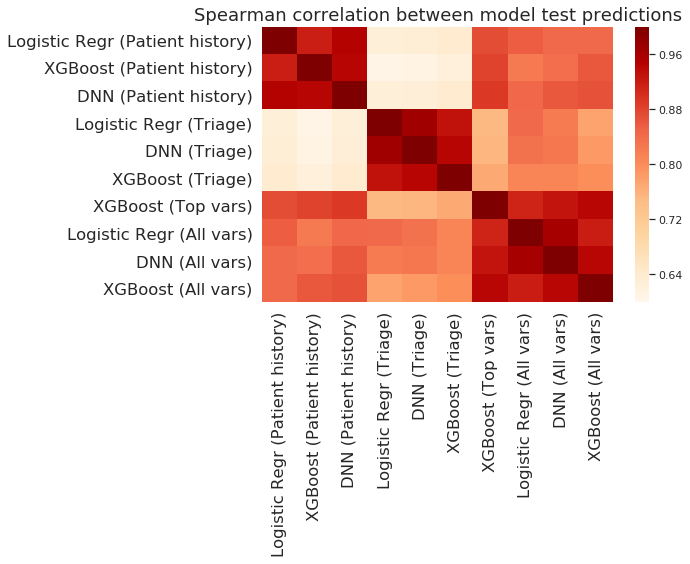

In [38]:
plt.figure(figsize=(10, 8))
plt.title('Spearman correlation between model test predictions')
sns.set(font_scale=1)
df = pd.DataFrame(np.corrcoef(prediction_mat))
df.rename(index={i: l for (i, l) in enumerate(labels)}, inplace=True)
df.columns = labels
sns.heatmap(df, cmap='OrRd', vmin=0.6, vmax=1)
plt.tight_layout()
plt.savefig(
    os.path.join(OUTPUT_DIR, 'correlation_heatmap.pdf'), dpi=300)

## comparison across models 

In [39]:
def get_N_misclassified_common(groupby_type, model_misclassified):
    for category, t_list in groupby_type.items():
        if len(t_list) == 1:
            continue
        type_misclassified = []
        for t in t_list:
            type_misclassified.append(model_misclassified[t])
        print(category, len(reduce(np.intersect1d, type_misclassified)))

In [40]:
get_N_misclassified_common(groupby_modeltype, model_misclassified)

lr 4080
bst 3041
keras 3794


In [41]:
get_N_misclassified_common(groupby_datatype, model_misclassified)

hx 6674
triage 7777
allvars 5230


In [42]:
len(set(model_misclassified['allvars.bst']) & set(model_misclassified['topvars.bst'])) 

6115

In [43]:
len(set(model_misclassified['allvars.keras']) & set(model_misclassified['allvars.lr'])) 

6946

In [44]:
len(set(model_misclassified['allvars.keras']) & set(model_misclassified['allvars.bst'])) 

6140

In [45]:
len(set(model_misclassified['allvars.lr']) & set(model_misclassified['allvars.bst'])) 

5781